Coupling map:


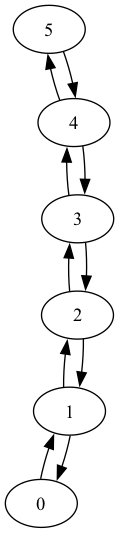

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

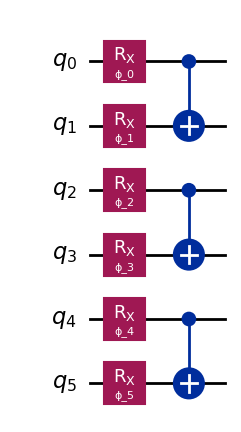

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


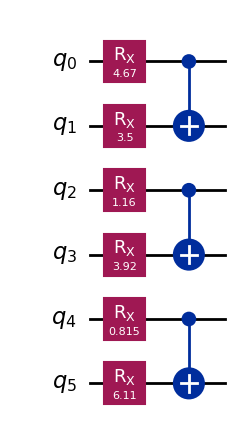

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


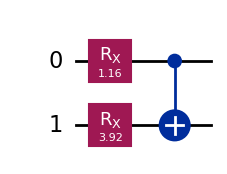

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

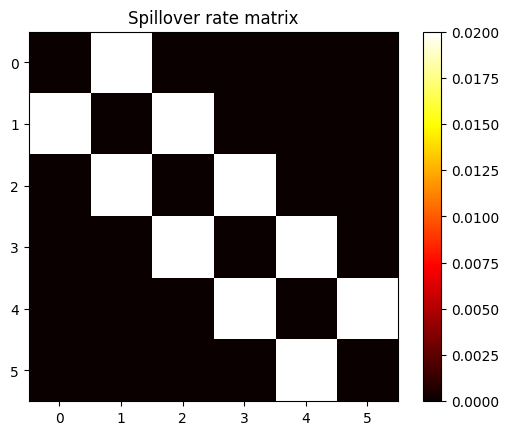

In [6]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.3  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Realistic Noise
gamma_first = 0.02
gamma_second = 0.0
gamma_matrix = gamma_first * np.diag(np.ones(num_qubits - 1), 1)
gamma_matrix += gamma_first * np.diag(np.ones(num_qubits - 1), -1)
gamma_matrix += gamma_second * np.diag(np.ones(num_qubits - 2), 2)
gamma_matrix += gamma_second * np.diag(np.ones(num_qubits - 2), -2)

# gamma_matrix = 0.05 * np.eye(num_qubits)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [7]:
gamma_matrix

array([[0.  , 0.02, 0.  , 0.  , 0.  , 0.  ],
       [0.02, 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.02, 0.  , 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.  , 0.02, 0.  , 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.02, 0.  ]])

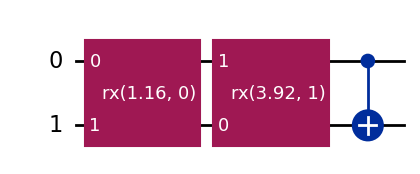

In [8]:
pass_ = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
pm = PassManager([pass_])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [9]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        -0.54833478j, 0.83625892+0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.83625892+0.j        , 0.        -0.54833478j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        -0.92432454j, -0.38160732+0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,

In [10]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '215afb06edb64f0b945f6d114ad08433',
   'operations': ['rx(1.16, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99724808+0.j        , 0.        -0.07413687j,
               0.        +0.j        , 0.        +0.j        ],
              [0.        -0.07413687j, 0.99724808+0.j        ,
               0.        +0.j        , 0.        +0.j        ],
              [0.        +0.j        , 0.        +0.j        ,
               0.99724808+0.j        , 0.        -0.07413687j],
              [0.        +0.j        , 0.        +0.j        ,
               0.        -0.07413687j, 0.99724808+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': 'be6674ca3d32456d8ee7f00fcf8fa30e',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99980486+0.j        , 0.        +0.j        ,
       

In [12]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager([pass_] + full_pm.translation._tasks[0])
full_pm.translation = custom_translation_pass

In [13]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x157d90610>,

In [14]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [15]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '215afb06edb64f0b945f6d114ad08433',
   'operations': ['rx(1.16, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99724808+0.j        , 0.        -0.07413687j,
               0.        +0.j        , 0.        +0.j        ],
              [0.        -0.07413687j, 0.99724808+0.j        ,
               0.        +0.j        , 0.        +0.j        ],
              [0.        +0.j        , 0.        +0.j        ,
               0.99724808+0.j        , 0.        -0.07413687j],
              [0.        +0.j        , 0.        +0.j        ,
               0.        -0.07413687j, 0.99724808+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': 'be6674ca3d32456d8ee7f00fcf8fa30e',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.99980486+0.j        , 0.        +0.j        ,
       

In [16]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


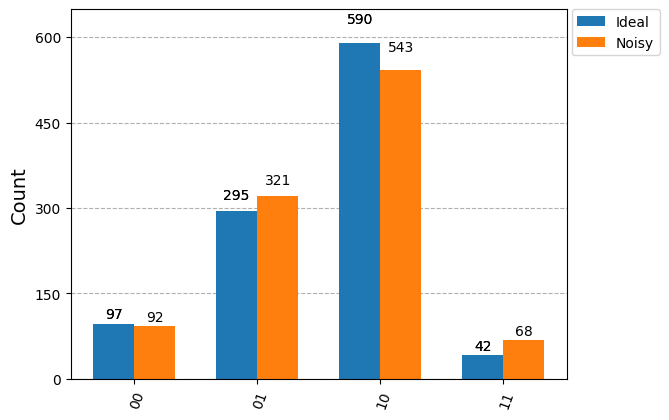

In [17]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [18]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [19]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9929578228152529

In [20]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [21]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)
# from gate_level.spillover_noise_use_case.generic_spillover.local_spillover_env import (
#     LocalSpilloverEnvironment,
# )

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="channel",
    env_metadata=env_metadata,
)
# q_env = LocalSpilloverEnvironment(
#     q_env_config,
#     circuit_context=circuit.assign_parameters(param_dict),  # Pass the circuit already transpiled through custom pass
# )
q_env = ArbitraryAngleSpilloverEnv(
    q_env_config, unbound_circuit_context=circuit, gamma_matrix=gamma_matrix
)

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [22]:
# Testing n-reps fitting

from typing import Callable, Any, Optional, List, Literal
from scipy.optimize import curve_fit

def _fit_function(n, eps_quad):
    return 3/5 + 2/5 * np.cos(n * eps_quad)

def _fit_function_2(n, delta_1, delta_2):
    return (4 * np.cos(n * delta_1)**2 * np.cos(n * delta_2)**2 + 1) / 5

def _inverse_fit_function(reward, n, spam, eps_lin, eps_quad):
    return reward + eps_lin * (n - 1) + eps_quad * (n**2 - 1)

def custom_reward_fit(
    env,
    params: np.array,
    execution_config: Optional[ExecutionConfig] = None,
    fit_function: Optional[Callable] = None,
    inverse_fit_function: Optional[Callable] = None,
    update_fit_params: bool = True,
    reward_method: Optional[
        Literal["cafe", "channel", "orbit", "state", "xeb", "fidelity"]
    ] = None,
) -> plt.Figure:
    """
    Method to fit the initial reward function to the first set of actions in the environment
    with respect to the number of repetitions of the cycle circuit
    """

    initial_execution_config = env.config.execution_config
    initial_reward_method = env.config.reward_method
    if execution_config is not None:
        env.config.execution_config = execution_config
    if reward_method is not None:
        env.config.reward_method = reward_method
    reward_data = []
    for i in range(len(env.config.execution_config.n_reps)):
        env.config.execution_config.n_reps_index = i
        reward = env.perform_action(params, update_env_history=False)
        reward_data.append(np.mean(reward))
    if fit_function is None or inverse_fit_function is None:
        fit_function = _fit_function_2
        inverse_fit_function = _inverse_fit_function

    p0 = [0.1, 0.1]  # Initial guess for the parameters
    lower_bounds = [0.0, 0.0]
    upper_bounds = [10., 10.]

    popt, pcov = curve_fit(
        fit_function,
        env.config.execution_config.n_reps,
        reward_data,
        p0=p0,
        bounds=(lower_bounds, upper_bounds),
    )

    # Create a figure and return it to the user
    fig, ax = plt.subplots()
    ax.plot(
        env.config.execution_config.n_reps, reward_data, label="Data", marker="o"
    )
    ax.plot(
        env.config.execution_config.n_reps,
        [fit_function(n, *popt) for n in env.config.execution_config.n_reps],
        label="Fit",
    )
    ax.set_xlabel("Number of repetitions")
    ax.set_ylabel("Reward")
    ax.legend()
    ax.set_title("Initial reward fit (for varying number of repetitions)")
    # Print found parameters
    print("Found parameters:", popt)

    if execution_config is not None:
        env.config.execution_config = initial_execution_config
    if reward_method is not None:
        env.config.reward_method = initial_reward_method
    if update_fit_params:
        env._fit_function = lambda reward, n: inverse_fit_function(
            reward, n, *popt
        )
        env._fit_params = popt
    return fig, reward_data

In [23]:
_obs, info = q_env.reset(seed=seed)

Sampled angles:  [3.33963104 5.58711255 3.74894089 1.44824163 2.33898309 4.5937506 ]


Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9863012772329395


Reward (avg): 0.9829714439911441 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9863012772329395
Reward (avg): 0.982978965825229 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9863012772329395
Reward (avg): 0.9086315287484096 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9863012772329395
Reward (avg): 0.8860500290947367 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9863012772329395
Reward (avg): 0.865995522307793 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9863012772329395
Reward (avg): 0.7554766126022048 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9863012772329395
Reward (avg): 0.7089299703341754 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9863012772329395
Reward (

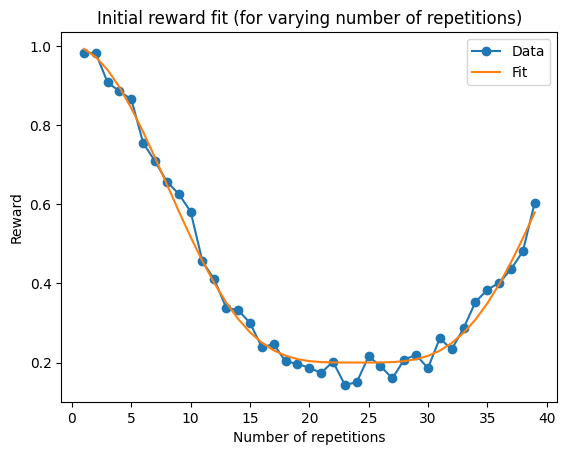

In [28]:
n_rep_vals = list(range(1, 40,), )

fig, reward_data = custom_reward_fit(
    q_env,
    np.zeros((1, 7)),
    # opt_action,
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=n_rep_vals,
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="channel",
)

In [27]:
y_data_fidelity = np.array(reward_data)

In [29]:
y_data = np.array(reward_data)
x_data = np.array(n_rep_vals)
y_data = np.clip(y_data, a_min=0., a_max=1 - 1e-6)

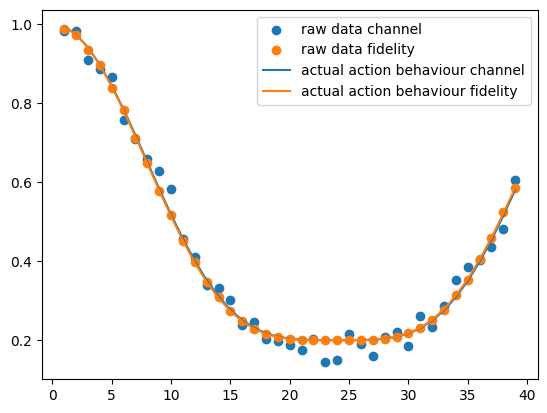

In [30]:
plt.scatter(x_data, y_data, label='raw data channel')
plt.scatter(x_data, y_data_fidelity, label='raw data fidelity')
plt.plot(x_data, _fit_function_2(x_data, 0.06537814, 0.06537823), label='actual action behaviour channel')
plt.plot(x_data, _fit_function_2(x_data, 0.06831464, 0.06327121), label='actual action behaviour fidelity')
# plt.plot(x_data, _fit_function(x_data, 0.3), label='zero action behaviour')
plt.legend()
plt.show()

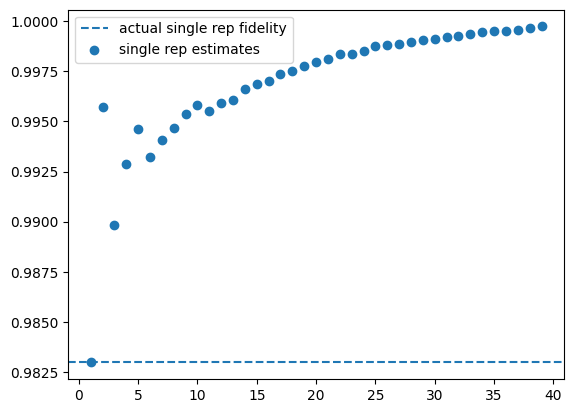

In [31]:
# Testing inverting approximation in two qubit setting

single_rep_estimates = 1 - (1 - y_data) / x_data**2

plt.axhline(y=y_data[0], label='actual single rep fidelity', linestyle='dashed')
plt.scatter(x_data, single_rep_estimates, label='single rep estimates')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import fsolve

# Input fidelities and n-reps
F_n1 = 0.95  # Example fidelity for n1 repetitions
F_n2 = 0.90  # Example fidelity for n2 repetitions
n1 = 2       # Number of repetitions for first measurement
n2 = 4       # Number of repetitions for second measurement

# Step 1: Compute a_n1 and a_n2
a_n1 = (5 * F_n1 - 1) / 4
a_n2 = (5 * F_n2 - 1) / 4

# Step 2: Define the system of equations
def equations(vars):
    delta1, delta2 = vars
    eq1 = np.cos(n1 * delta1 / 2)**2 * np.cos(n1 * delta2 / 2)**2 - a_n1
    eq2 = np.cos(n2 * delta1 / 2)**2 * np.cos(n2 * delta2 / 2)**2 - a_n2
    return [eq1, eq2]

# Step 3: Solve numerically (initial guess: small deltas)
initial_guess = [0.1, 0.1]
delta1, delta2 = fsolve(equations, initial_guess)

# Step 4: Compute single-cycle fidelity
a_1 = np.cos(delta1 / 2)**2 * np.cos(delta2 / 2)**2
F_avg_1 = (4 * a_1 + 1) / 5

print(f"Estimated single-cycle fidelity: {F_avg_1:.4f}")
print(f"Solved delta1: {delta1:.4f}, delta2: {delta2:.4f}")